# Initializing Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install arabert
!pip install transformers

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from arabert.preprocess import ArabertPreprocessor
from transformers import AutoTokenizer,AutoModel
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,Dropout,Conv1D,MaxPooling1D,Reshape
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
%cd /content/drive/MyDrive/Gp\ Dataset

/content/drive/MyDrive/Gp Dataset


# Load Data

In [ ]:
labeledData=pd.read_csv('labeled_data.csv')

In [ ]:
labeledData = labeledData.sample(frac=1, random_state=np.random.RandomState(seed=56))

In [ ]:

labeledData['label']=labeledData['label'].replace(['not credible','credible'],[0,1])
real = labeledData[labeledData['label']==1]
fake = labeledData[labeledData['label']==0]
real = real.sample(n=len(fake), random_state=101)
labeledData = pd.concat([real,fake],axis=0)


In [ ]:
labeledData = labeledData.sample(frac=0.25, random_state=np.random.RandomState(seed=42))
labeledData = labeledData.reset_index(drop=True)

In [ ]:
print(labeledData.shape)
labeledData.head()

(83616, 5)


,title,text,publishing_date,source_num,label
0,الإمارات وأوزبكستان توقعان على برنامج تعاون اق...,أنا معجب بالشروق بالفعل، لا تظهر هذه الرسالة م...,2021-04-07T17:33:54,source_86,1
1,84 وفاة جديدة بفيروس كورونا و2123 اصابة جديدة,أعلنت وزارة الصحة تسجيل 84 وفاة جديدة بفيروس ك...,2021-04-14T21:27:04+02:00,source_75,1
2,في ظرف وجيز.. عناصر أمن الدائرة الأولى توقف ال...,ناظورسيتي: محمد محمود\n\nفي وقت وجيز، وتحت إشر...,2021-05-19T00:00:00,source_50,0
3,بالأسماء.. إصابة 5 أشخاص بينهم طفلين إثر انقلا...,كتب : قنا: سمر مكي\n\nأصيب اثنان، اليوم الخميس...,2021-05-06T19:52:48,source_23,1
4,مجلس الوزراء: مصر تحتل المركز الأول إقليمياً و...,احتلت مصر المركز الأول إقليمياً وقارياً والـ 1...,2021-05-28T10:11:20,source_86,1


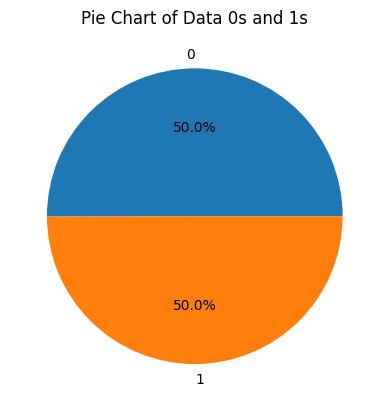

In [ ]:
data_value_counts=labeledData['label'].value_counts()
plt.pie(data_value_counts,labels=data_value_counts.index,autopct='%1.1f%%')
plt.title('Pie Chart of Data 0s and 1s')
plt.show()

In [ ]:
# #preprocessed=[arabert_prep.preprocess(txtt) for txtt in train_text]
# train_text,temp_text,train_labels,temp_labels=train_test_split(labeledData['title'],labeledData['label'],random_state=50,test_size=0.2)
# val_text,test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,random_state=50,test_size=0.5)

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)
preprocessed=[arabert_prep.preprocess(txtt) for txtt in labeledData['title']]
train_text,temp_text,train_labels,temp_labels=train_test_split(preprocessed,labeledData['label'],random_state=50,test_size=0.2)
val_text,test_text,val_labels,test_labels=train_test_split(temp_text,temp_labels,random_state=50,test_size=0.1)

[2023-04-26 16:14:04,548 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


# Bert

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_tokenizer=AutoTokenizer.from_pretrained(model_name)
arabert_model = AutoModel.from_pretrained(model_name)

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Text(0, 0.5, 'Number Of Texts')

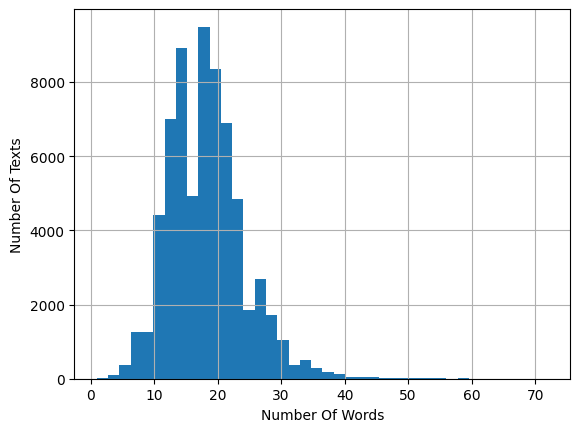

In [ ]:
lengths=[len(title.split()) for title in train_text]
pd.Series(lengths).hist(bins=40)
plt.xlabel('Number Of Words')
plt.ylabel('Number Of Texts')

In [ ]:
sample_texts = ["مرحبا بالعالم","أنا أحب تعلم اللغات الجديدة"]
#preprocessed=txt=[arabert_prep.preprocess(txtt) for txtt in sample_texts]
tokenized_sample=arabert_tokenizer.batch_encode_plus(sample_texts,padding=True)
tokenized_sample

{'input_ids': [[33, 9950, 195, 4350, 4372, 199, 34, 31, 31], [33, 1412, 4454, 3305, 2929, 55278, 27099, 51659, 34]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
max_len=24
tokens_train=arabert_tokenizer.batch_encode_plus(
    train_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )
tokens_val=arabert_tokenizer.batch_encode_plus(
    val_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )
tokens_test=arabert_tokenizer.batch_encode_plus(
    test_text,
    max_length=max_len,
    padding="max_length",
    truncation=True
    )

In [ ]:
train_input_ids=torch.tensor(tokens_train['input_ids'])
train_attention_masks=torch.tensor(tokens_train['attention_mask'])
train_y=torch.tensor(train_labels.tolist())

test_input_ids=torch.tensor(tokens_test['input_ids'])
test_attention_masks=torch.tensor(tokens_test['attention_mask'])
test_y=torch.tensor(test_labels.tolist())

val_input_ids=torch.tensor(tokens_val['input_ids'])
val_attention_masks=torch.tensor(tokens_val['attention_mask'])
val_y=torch.tensor(val_labels.tolist())

In [ ]:
type(train_input_ids)

torch.Tensor

In [ ]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size

train_data = TensorDataset(train_input_ids, train_attention_masks, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_input_ids, val_attention_masks, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

# Freeze Bert Layers

In [ ]:
for param in arabert_model.parameters():
    param.requires_grad = False  

# Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):  
      super(BERT_Arch, self).__init__()
      self.bert = bert   
      self.dropout = nn.Dropout(0.1)            # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass  
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(arabert_model)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss() 
# Number of training epochs
epochs = 2

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Model Functions

In [ ]:
# Defining training and evaluation functions
def train():  
  model.train()
  total_loss, total_accuracy = 0, 0
  
  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch 
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch  
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():  
  print("\nEvaluating...")  
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0  
  for step,batch in enumerate(val_dataloader):    # Iterate over batches  
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.     
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

# Load Previous model if needed

In [ ]:
model.load_state_dict(torch.load('c3_new_model_weights.pt'))

# Train Model

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(1):     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))     
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c4_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of  2,091.
  Batch   100  of  2,091.
  Batch   150  of  2,091.
  Batch   200  of  2,091.
  Batch   250  of  2,091.
  Batch   300  of  2,091.
  Batch   350  of  2,091.
  Batch   400  of  2,091.
  Batch   450  of  2,091.
  Batch   500  of  2,091.
  Batch   550  of  2,091.
  Batch   600  of  2,091.
  Batch   650  of  2,091.
  Batch   700  of  2,091.
  Batch   750  of  2,091.
  Batch   800  of  2,091.
  Batch   850  of  2,091.
  Batch   900  of  2,091.
  Batch   950  of  2,091.
  Batch 1,000  of  2,091.
  Batch 1,050  of  2,091.
  Batch 1,100  of  2,091.
  Batch 1,150  of  2,091.
  Batch 1,200  of  2,091.
  Batch 1,250  of  2,091.
  Batch 1,300  of  2,091.
  Batch 1,350  of  2,091.
  Batch 1,400  of  2,091.
  Batch 1,450  of  2,091.
  Batch 1,500  of  2,091.
  Batch 1,550  of  2,091.
  Batch 1,600  of  2,091.
  Batch 1,650  of  2,091.
  Batch 1,700  of  2,091.
  Batch 1,750  of  2,091.
  Batch 1,800  of  2,091.
  Batch 1,850  of  2,091.
  Batch 1,900  of  2,091

In [ ]:
print(evaluate())


Evaluating...
  Batch    50  of    527.
  Batch   100  of    527.
  Batch   150  of    527.
  Batch   200  of    527.
  Batch   250  of    527.
  Batch   300  of    527.
  Batch   350  of    527.
  Batch   400  of    527.
  Batch   450  of    527.
  Batch   500  of    527.
0.6323431921412416


# Test

In [ ]:
model.load_state_dict(torch.load('c2_new_model_weights.pt'))

<All keys matched successfully>

In [ ]:
from sklearn.metrics import classification_report
# test_input_ids=torch.tensor(tokens_test['input_ids'])
# test_attention_masks=torch.tensor(tokens_test['attention_mask'])
# test_y=torch.tensor(test_labels.tolist())
with torch.no_grad():
  preds = model(test_input_ids, test_attention_masks)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.63      0.68      0.65       839
           1       0.65      0.60      0.62       834

    accuracy                           0.64      1673
   macro avg       0.64      0.64      0.64      1673
weighted avg       0.64      0.64      0.64      1673

